# Лабораторная работа №3: Обнаружение границ и сегментация изображений

**Цель**: Освоить классические методы обнаружения границ и сегментации объектов на изображениях.

**Задачи**:
1. Применить детекторы границ (Sobel, Canny).
2. Выполнить пороговую сегментацию (глобальная, адаптивная, Otsu).
3. Реализовать сегментацию методом водораздела (watershed).

**Пример применения**: выделение деталей на конвейере СТО.

In [ ]:
# !pip install opencv-python numpy matplotlib

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Загрузка изображения

In [4]:
img = cv2.imread('rock.jpg')  # <-- укажите путь к изображению с деталями
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## 2. Обнаружение границ

In [5]:
# ЗАДАНИЕ: примените Sobel и Canny
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = np.sqrt(sobelx**2 + sobely**2)

canny_edges = cv2.Canny(gray, threshold1=100, threshold2=200)

## 3. Пороговая сегментация

In [6]:
# Глобальный порог
_, thresh_global = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Адаптивный порог
thresh_adaptive = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
)

# Otsu
_, thresh_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

## 4. Сегментация методом водораздела

In [8]:
# Подготовка маркеров
ret, sure_fg = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# ЗАДАНИЕ: выполните морфологическое расширение для фона
kernel = np.ones((3,3), np.uint8)
sure_bg = cv2.dilate(gray, kernel, iterations=3)

# Получение неопределённой области
sure_fg = cv2.erode(gray, kernel, iterations=3)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Маркировка
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Применение watershed
img_watershed = img.copy()
markers = cv2.watershed(img_watershed, markers)
img_watershed[markers == -1] = [255, 0, 0]  # границы — синим

## 5. Визуализация

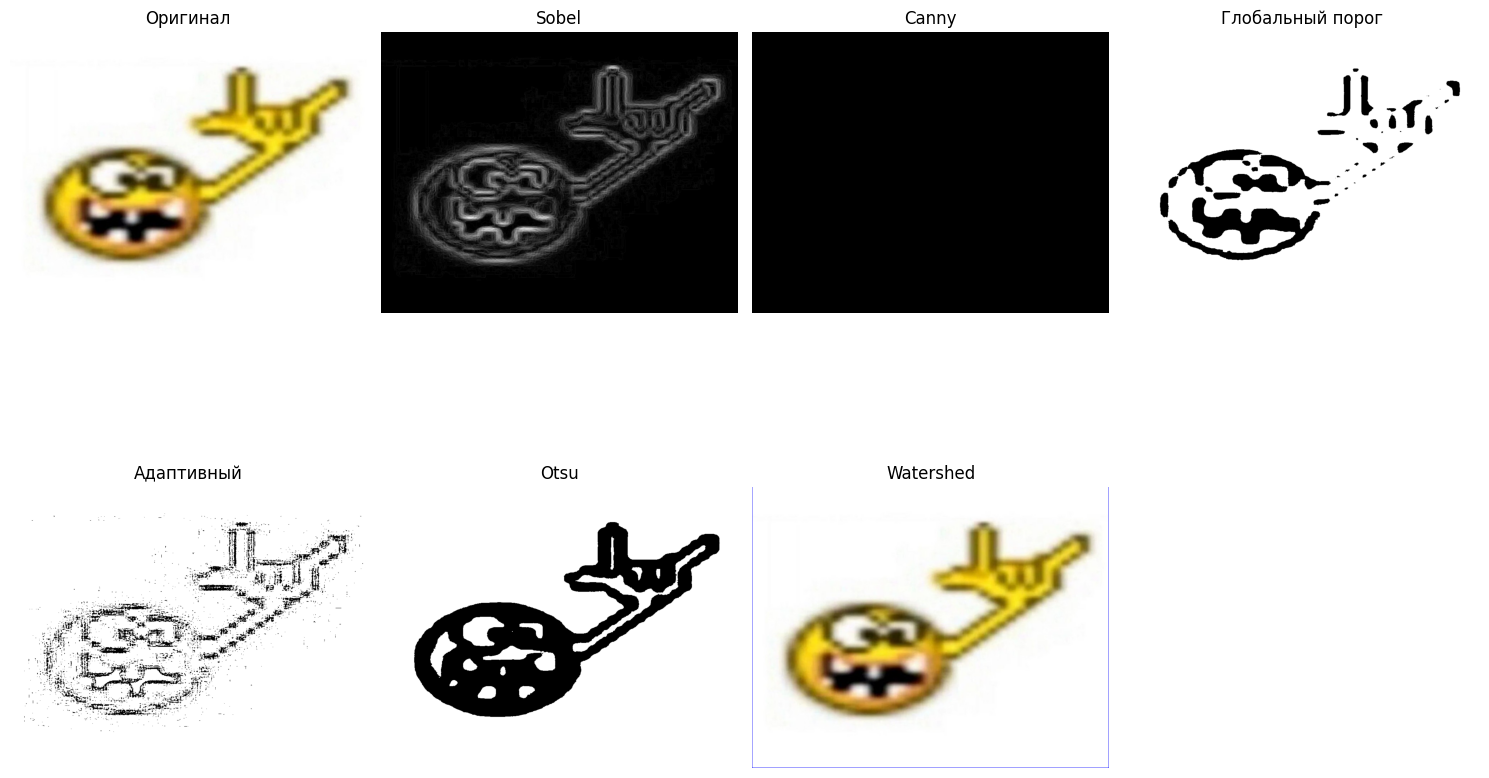

In [9]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 4, 1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title('Оригинал'); plt.axis('off')
plt.subplot(2, 4, 2); plt.imshow(sobel_combined, cmap='gray'); plt.title('Sobel'); plt.axis('off')
plt.subplot(2, 4, 3); plt.imshow(canny_edges, cmap='gray'); plt.title('Canny'); plt.axis('off')
plt.subplot(2, 4, 4); plt.imshow(thresh_global, cmap='gray'); plt.title('Глобальный порог'); plt.axis('off')
plt.subplot(2, 4, 5); plt.imshow(thresh_adaptive, cmap='gray'); plt.title('Адаптивный'); plt.axis('off')
plt.subplot(2, 4, 6); plt.imshow(thresh_otsu, cmap='gray'); plt.title('Otsu'); plt.axis('off')
plt.subplot(2, 4, 7); plt.imshow(cv2.cvtColor(img_watershed, cv2.COLOR_BGR2RGB)); plt.title('Watershed'); plt.axis('off')

plt.tight_layout()
plt.show()

## Выводы

Какой метод лучше справляется с перекрывающимися объектами? В каких условиях Otsu даёт сбой?

## Контрольные вопросы:

1. В чём принцип работы оператора Canny? Какие этапы он включает?
2. Почему Sobel-оператор чувствителен к шуму? Как это компенсируется на практике?
3. Как работает метод Otsu? При каких условиях он даёт неудовлетворительные результаты?
4. В чём разница между глобальной и адаптивной пороговой сегментацией?
5. Почему метод водораздела (watershed) может приводить к пере-сегментации? Как этого избежать?
6. Как морфологические операции (эрозия, дилатация) помогают улучшить сегментацию?
7. Можно ли использовать watershed для сегментации перекрывающихся резервуаров на спутниковом снимке? Обоснуйте.
8. Как выбрать оптимальный размер ядра для морфологических операций?

## Ответы на контрольные вопросы

1. **Принцип Canny:** поиск границ по резкому изменению яркости. Этапы: (а) сглаживание (обычно Gaussian), (б) расчёт градиента (модуль и направление), (в) подавление немаксимумов, (г) двойной порог, (д) трассировка границ по гистерезису.
2. **Почему Sobel шумочувствителен:** Sobel вычисляет производную, а производные усиливают высокочастотные компоненты (в т.ч. шум). Компенсация: предварительное сглаживание (Gaussian/median), корректный порог, иногда больший размер ядра и постобработка морфологией.
3. **Как работает Otsu:** автоматически выбирает порог, максимизируя межклассовую дисперсию (эквивалентно минимизации внутриклассовой). Плохо работает при неравномерном освещении, слабом контрасте классов, сильном шуме, многомодальном/небимодальном гистограммном распределении.
4. **Глобальная vs адаптивная пороговая:** глобальная использует один порог для всего изображения; адаптивная вычисляет локальный порог по окрестности каждого пикселя. Адаптивная устойчивее к теням и перепадам освещённости, но чувствительна к размеру окна.
5. **Почему watershed пере-сегментирует:** каждый локальный минимум может стать отдельным бассейном, поэтому шум/текстура дробят объект на множество областей. Как избежать: сглаживание, маркер-контролируемый watershed, подавление мелких минимумов, морфологическая предобработка.
6. **Роль морфологии:** эрозия удаляет мелкий шум и разъединяет слипшиеся светлые объекты; дилатация расширяет области и закрывает мелкие разрывы. Комбинации opening/closing очищают маску, сглаживают границы и заполняют мелкие отверстия.
7. **Watershed для перекрывающихся резервуаров:** да, но лучше в marker-controlled варианте. Нужны хорошие маркеры (например, после пороговой сегментации/дистанционного преобразования) и предобработка, иначе тени, блики и неоднородный фон на спутниковом снимке дадут много ложных областей.
8. **Выбор размера ядра:** ориентироваться на масштаб шума и объектов: ядро должно быть больше типичного шума, но меньше значимых деталей объекта. Практика: начать с 3x3/5x5, затем подобрать по метрикам (IoU, Dice) или визуально на валидационном наборе.